<a href="https://colab.research.google.com/github/EoAraujo/ML_Rogerio/blob/main/Trabalho_Rogerio_Eduardo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem do Patrimônio de Candidatos
análise exploratória para gerar sobre os bens declarados por candidatos e prever o valor de um bem.

In [ ]:
# Importação de todas as bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

## reparação dos Dados

Carregar os dados, limpamos nomes de colunas, convertemos tipos, tratamos valores ausentes e removemos outliers

In [ ]:
# --- 1. CARREGAMENTO E PREPARAÇÃO ---
url = "https://gist.githubusercontent.com/EoAraujo/e679b9abae562db122a8d433e7816324/raw"
df = pd.read_csv(url, sep=';')

df.columns = df.columns.str.strip()

df['DT_ULT_ATUAL_BEM_CANDIDATO'] = pd.to_datetime(df['DT_ULT_ATUAL_BEM_CANDIDATO'], format='%d/%m/%Y')
df['VR_BEM_CANDIDATO'] = df['VR_BEM_CANDIDATO'].astype(str).str.replace(',', '.').astype(float)
df['DS_BEM_CANDIDATO'] = df['DS_BEM_CANDIDATO'].fillna('Desconhecido')

Q1 = df['VR_BEM_CANDIDATO'].quantile(0.25)
Q3 = df['VR_BEM_CANDIDATO'].quantile(0.75)
IQR = Q3 - Q1
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR
df_clean = df[(df['VR_BEM_CANDIDATO'] >= low) & (df['VR_BEM_CANDIDATO'] <= high)].copy()

df_clean['Ano_Atual'] = df_clean['DT_ULT_ATUAL_BEM_CANDIDATO'].dt.year
df_clean['Tipo_Cod'] = df_clean['DS_TIPO_BEM_CANDIDATO'].astype('category').cat.codes

print("--- DADOS PRONTOS PARA ANÁLISE E MODELAGEM ---")
print(f"Shape do DataFrame após limpeza: {df_clean.shape}")

--- DADOS PRONTOS PARA ANÁLISE E MODELAGEM ---
Shape do DataFrame após limpeza: (2384, 21)


Aqui, investigar os dados para extrair insights sobre a distribuição da riqueza.

--- Análise 1: Top 10 Candidatos por Patrimônio ---


/tmp/ipython-input-3-3288721669.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patrimonio_por_candidato.values, y=patrimonio_por_candidato.index, palette='viridis', orient='h')


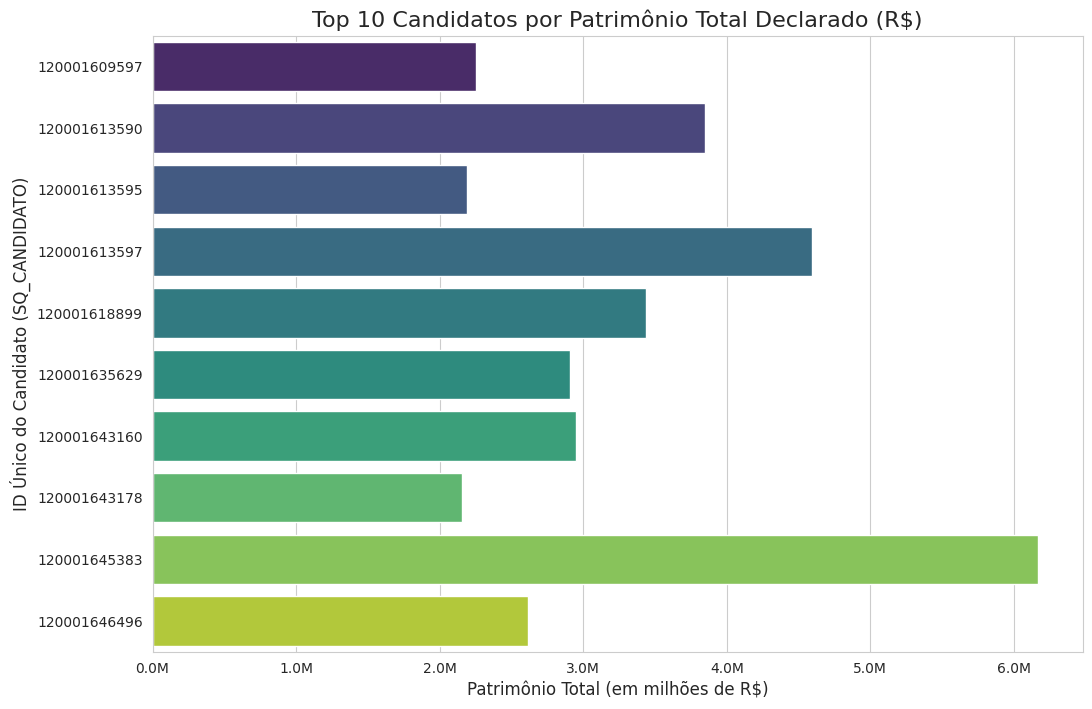

In [ ]:
print("--- Análise 1: Top 10 Candidatos por Patrimônio ---")
patrimonio_por_candidato = df_clean.groupby('SQ_CANDIDATO')['VR_BEM_CANDIDATO'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=patrimonio_por_candidato.values, y=patrimonio_por_candidato.index, palette='viridis', orient='h')
plt.title('Top 10 Candidatos por Patrimônio Total Declarado (R$)', fontsize=16)
plt.xlabel('Patrimônio Total (em milhões de R$)', fontsize=12)
plt.ylabel('ID Único do Candidato (SQ_CANDIDATO)', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x/1e6:.1f}M"))
plt.show()


--- Análise 2: Análise de Bens por Tipo ---


/tmp/ipython-input-4-1914708223.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=valor_por_tipo_bem['sum'].head(10), y=valor_por_tipo_bem.index[:10], palette='plasma')


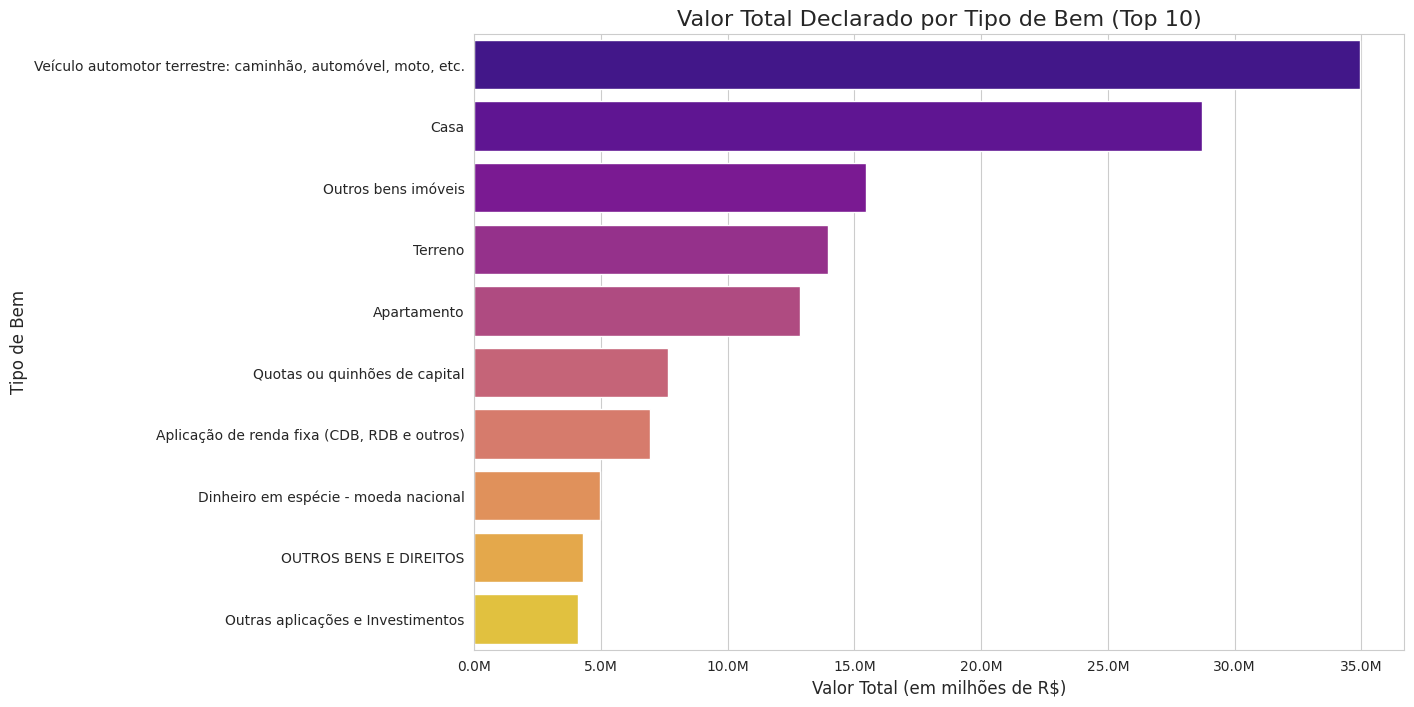

/tmp/ipython-input-4-1914708223.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=valor_por_tipo_bem_media['mean'].head(10), y=valor_por_tipo_bem_media.index[:10], palette='magma')


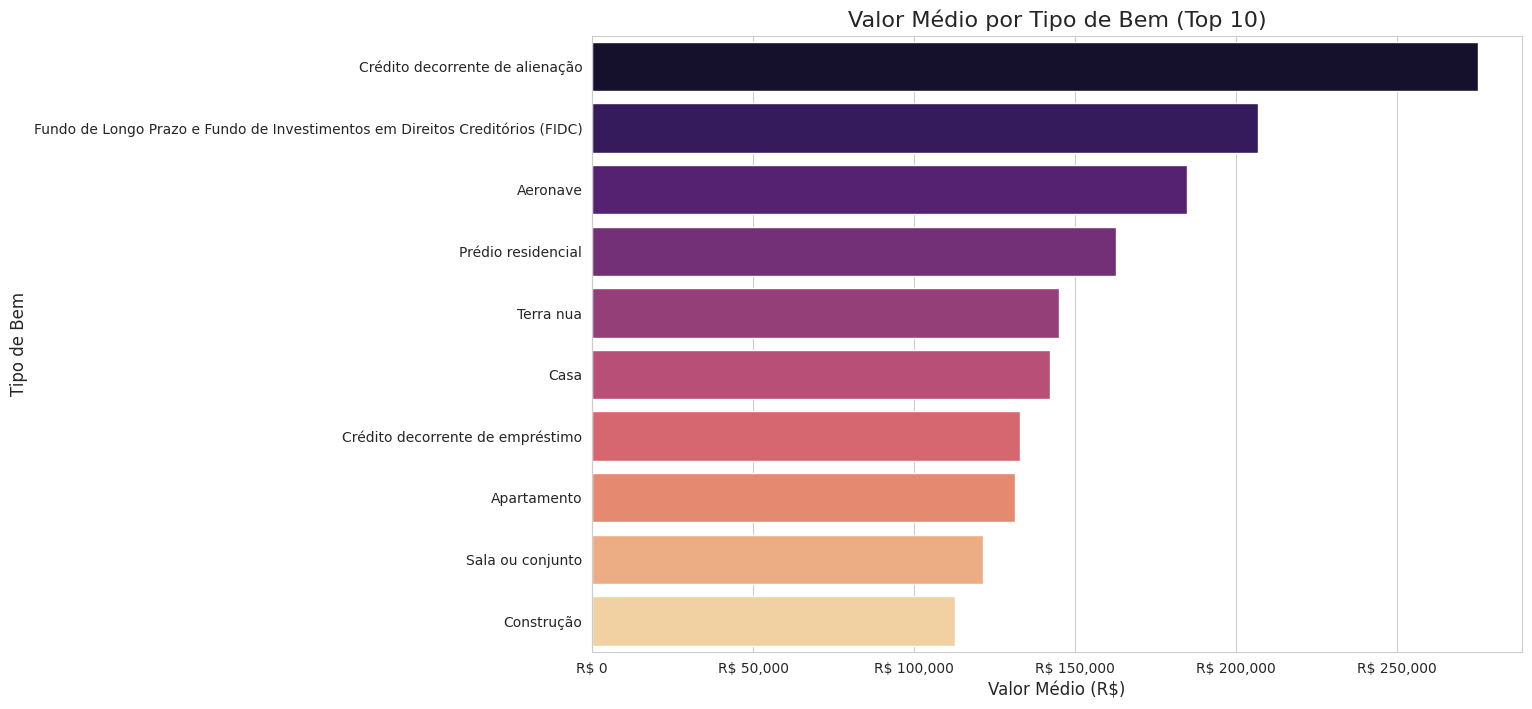

In [ ]:
print("\n--- Análise 2: Análise de Bens por Tipo ---")
valor_por_tipo_bem = df_clean.groupby('DS_TIPO_BEM_CANDIDATO')['VR_BEM_CANDIDATO'].agg(['sum', 'mean']).sort_values(by='sum', ascending=False)

# Valor Total
plt.figure(figsize=(12, 8))
sns.barplot(x=valor_por_tipo_bem['sum'].head(10), y=valor_por_tipo_bem.index[:10], palette='plasma')
plt.title('Valor Total Declarado por Tipo de Bem (Top 10)', fontsize=16)
plt.xlabel('Valor Total (em milhões de R$)', fontsize=12)
plt.ylabel('Tipo de Bem', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x/1e6:.1f}M"))
plt.show()

# Valor Médio
valor_por_tipo_bem_media = valor_por_tipo_bem.sort_values(by='mean', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=valor_por_tipo_bem_media['mean'].head(10), y=valor_por_tipo_bem_media.index[:10], palette='magma')
plt.title('Valor Médio por Tipo de Bem (Top 10)', fontsize=16)
plt.xlabel('Valor Médio (R$)', fontsize=12)
plt.ylabel('Tipo de Bem', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"R$ {x:,.0f}"))
plt.show()


--- Análise 3: Distribuição Geográfica do Patrimônio ---


/tmp/ipython-input-5-720800771.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patrimonio_por_uf.index, y=patrimonio_por_uf.values, palette='cubehelix')


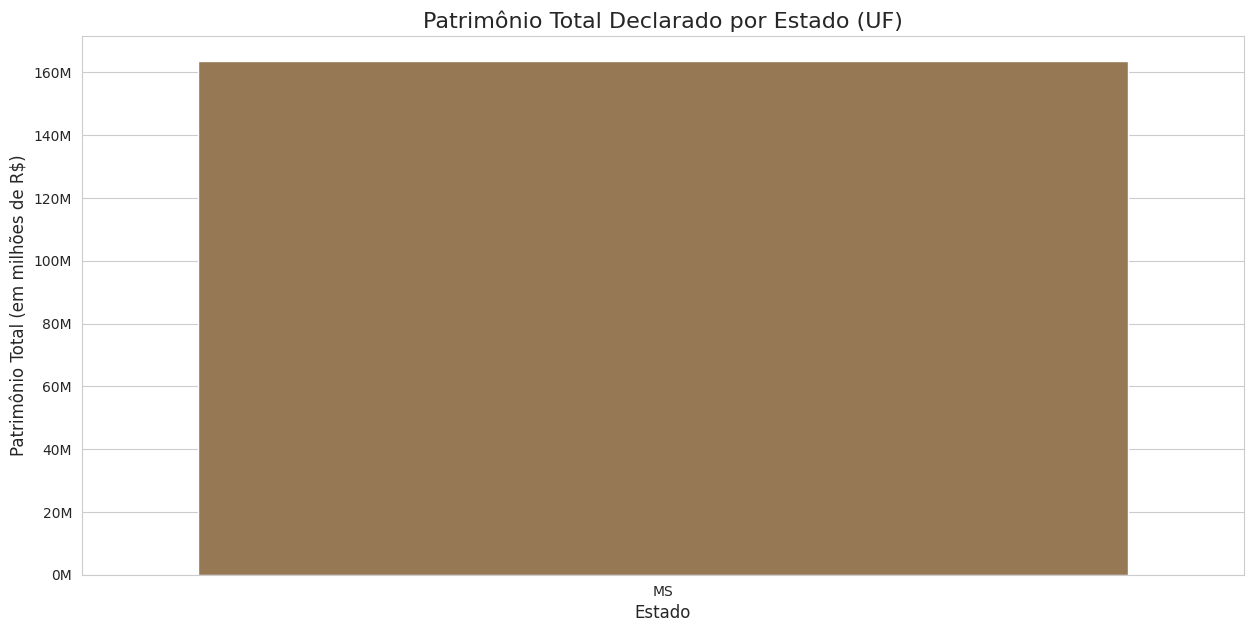

In [ ]:
print("\n--- Análise 3: Distribuição Geográfica do Patrimônio ---")
patrimonio_por_uf = df_clean.groupby('SG_UF')['VR_BEM_CANDIDATO'].sum().sort_values(ascending=False)
plt.figure(figsize=(15, 7))
sns.barplot(x=patrimonio_por_uf.index, y=patrimonio_por_uf.values, palette='cubehelix')
plt.title('Patrimônio Total Declarado por Estado (UF)', fontsize=16)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Patrimônio Total (em milhões de R$)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, loc: f"{y/1e6:.0f}M"))
plt.show()

##Modelagem Preditiva


In [ ]:

features = ['Ano_Atual', 'Tipo_Cod']
target = 'VR_BEM_CANDIDATO'

X = df_clean[features]
y = df_clean[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("--- DADOS PRONTOS PARA MODELAGEM ---")
print(f"Shape de X_train_scaled: {X_train_scaled.shape}")
print(f"Shape de X_test_scaled: {X_test_scaled.shape}")

--- DADOS PRONTOS PARA MODELAGEM ---
Shape de X_train_scaled: (1907, 2)
Shape de X_test_scaled: (477, 2)


treinar dois modelos diferentes para comparar seus desempenhos na tarefa de prever o valor de um bem.

In [ ]:
print("--- Modelo 1: Regressão Linear ---")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"MSE (Regressão Linear): {mse_lr:.2f}")
print(f"R² (Regressão Linear): {r2_lr:.4f}")

--- Modelo 1: Regressão Linear ---
MSE (Regressão Linear): 6797854042.13
R² (Regressão Linear): 0.0021


In [ ]:
print("\n--- Modelo 2: Random Forest Regressor ---")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"MSE (Random Forest): {mse_rf:.2f}")
print(f"R² (Random Forest): {r2_rf:.4f}")


--- Modelo 2: Random Forest Regressor ---
MSE (Random Forest): 6098005780.12
R² (Random Forest): 0.1049


##Conclusão

Comparar os resultados e analisamos quais features foram mais importantes para o melhor modelo.

--- CONCLUSÃO DA COMPARAÇÃO ---
O modelo Random Forest (R²=0.1049) teve um desempenho superior à Regressão Linear (R²=0.0021).

--- Análise de Importância das Features (pelo modelo Random Forest) ---


/tmp/ipython-input-9-1723554212.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket')


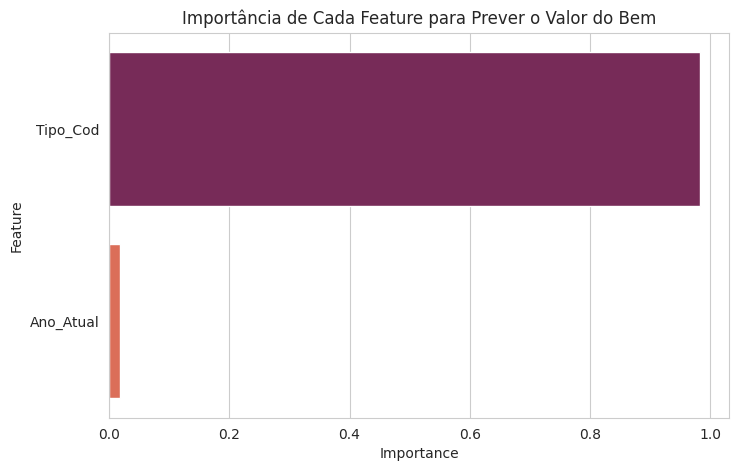

In [ ]:
print("--- CONCLUSÃO DA COMPARAÇÃO ---")
if r2_rf > r2_lr:
    print(f"O modelo Random Forest (R²={r2_rf:.4f}) teve um desempenho superior à Regressão Linear (R²={r2_lr:.4f}).\n")
else:
    print(f"A Regressão Linear (R²={r2_lr:.4f}) teve um desempenho superior ao Random Forest (R²={r2_rf:.4f}).\n")

print("--- Análise de Importância das Features (pelo modelo Random Forest) ---")
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket')
plt.title('Importância de Cada Feature para Prever o Valor do Bem')
plt.show()